In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("..")

from llama_index.llms.openai import OpenAI
from src.local_models.embeddings import get_embed_model

from src.data_loader.load_files import load_data
from src.data_loader.chunking import chunk_docs_standalone

from src.data_loader.load_from_dir import rebuild_index

from src.nebula_graph.nebula_operations import show_hosts, add_hosts_if_not_available, show_spaces, init_nebula_cluster
from src.nebula_graph.text_2_graph import df_to_fig, extract_triplets, get_response_n_kg_rel_query, get_response_n_kg_rel_chat

#from llama_index.core import Document
import os, re, ast

from dotenv import load_dotenv

In [ ]:
from llama_index.graph_stores.nebula import NebulaGraphStore
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader

from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


In [ ]:
load_dotenv(override=True)

In [ ]:
embed_model = get_embed_model(model_name=os.environ['embed_path'],  model_kwargs={'device': 'cpu'}, encode_kwargs = {'normalize_embeddings': True})
llm = OpenAI()

In [ ]:
add_hosts_if_not_available()
space_name = "zelda"

init_nebula_cluster(space_name)

edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [ ]:
#first-time build
documents = load_data(os.environ['data_path'])

In [ ]:
len(documents)

In [ ]:
kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [ ]:
kg_index.storage_context.persist(persist_dir="../db_stores/kg_index")

In [ ]:
kg_index = rebuild_index('../db_stores/kg_index')

In [ ]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=True,
    retriever_mode="hybrid",
    response_mode="tree_summarize",
)


In [54]:
response = kg_rag_query_engine.query("告诉我更多关于 动火工作票")
# 告诉我更多关于 动火工作审批人


In [55]:
resp, kg_rel_texts = get_response_n_kg_rel_query(response)
kg_rel_texts

["['动火工作许可人', '应由', '动火区域具备电气工作票工作许可人资格的运维单位人员担任']",
 "['一级动火工作票', '审核', '厂（局）安监部门负责人、消防管理负责人']",
 "['一级动火工作票', '批准', '厂（局）分管生产的负责人或总工程师']",
 "['二级动火工作票', '由', '申请动火作业班组班长或班组技术员签发']",
 "['一级动火工作票', '由', '申请动火部门负责人或技术负责人签发']",
 "['二级动火工作票', '审批', '动火区域运维单位安全监察部门']",
 "['动火工作负责人', '宜具备', '电气工作票工作负责人资格']",
 "['动火工作票签发人', '审查', '动火工作是否满足安全要求']",
 "['动火工作许可人', '应在', '动火作业现场确认并完成']",
 "['动火工作票签发人', '不得', '兼任动火工作负责人']",
 "['动火工作负责人', '不应担任', '动火工作负责人']",
 "['动火工作票签发人', '审查', '动火工作的必要性']",
 "['动火工作票签发人', '审查', '动火工作的安全性']",
 "['动火工作审批人', '审查', '动火工作的必要性']",
 "['动火工作审批人', '审查', '动火工作的安全性']",
 "['动火工作负责人', '检查', '现场有无残留火种']",
 "['二级动火工作票', '有效期为', '120h']",
 "['动火工作负责人', '监督', '现场动火工作']",
 "['动火工作许可人', '若无', '工作许可人员']",
 "['动火工作票', '包括', '动火工作票签发人']",
 "['动火工作票', '分为', '一级动火工作票']",
 "['一级动火工作票', '有效期为', '24h']",
 "['动火工作票', '包括', '动火工作审批人']",
 "['动火工作票', '包括', '动火工作负责人']",
 "['动火工作负责人', '办理', '动火工作票']",
 "['动火工作票', '分为', '二级动火工作票']",
 "['动火工作票', '包括', '动火工作许可人']",
 "['动火工作负责人', '组织', '动火工作']",
 

In [56]:
extracted_triplets = extract_triplets(kg_rel_texts)
extracted_triplets

,e1,r,e2
0,动火工作票,包括,动火工作许可人
1,动火工作票签发人,审查,动火工作的安全性
2,动火工作审批人,审查,动火工作的安全性
3,动火工作负责人,不应担任,动火工作负责人
4,二级动火工作票,有效期为,120h
5,动火工作票,包括,动火工作票签发人
6,动火工作票签发人,审查,动火工作是否满足安全要求
7,动火工作票,包括,动火工作审批人
8,动火工作负责人,宜具备,电气工作票工作负责人资格
9,动火工作票,包括,动火工作负责人


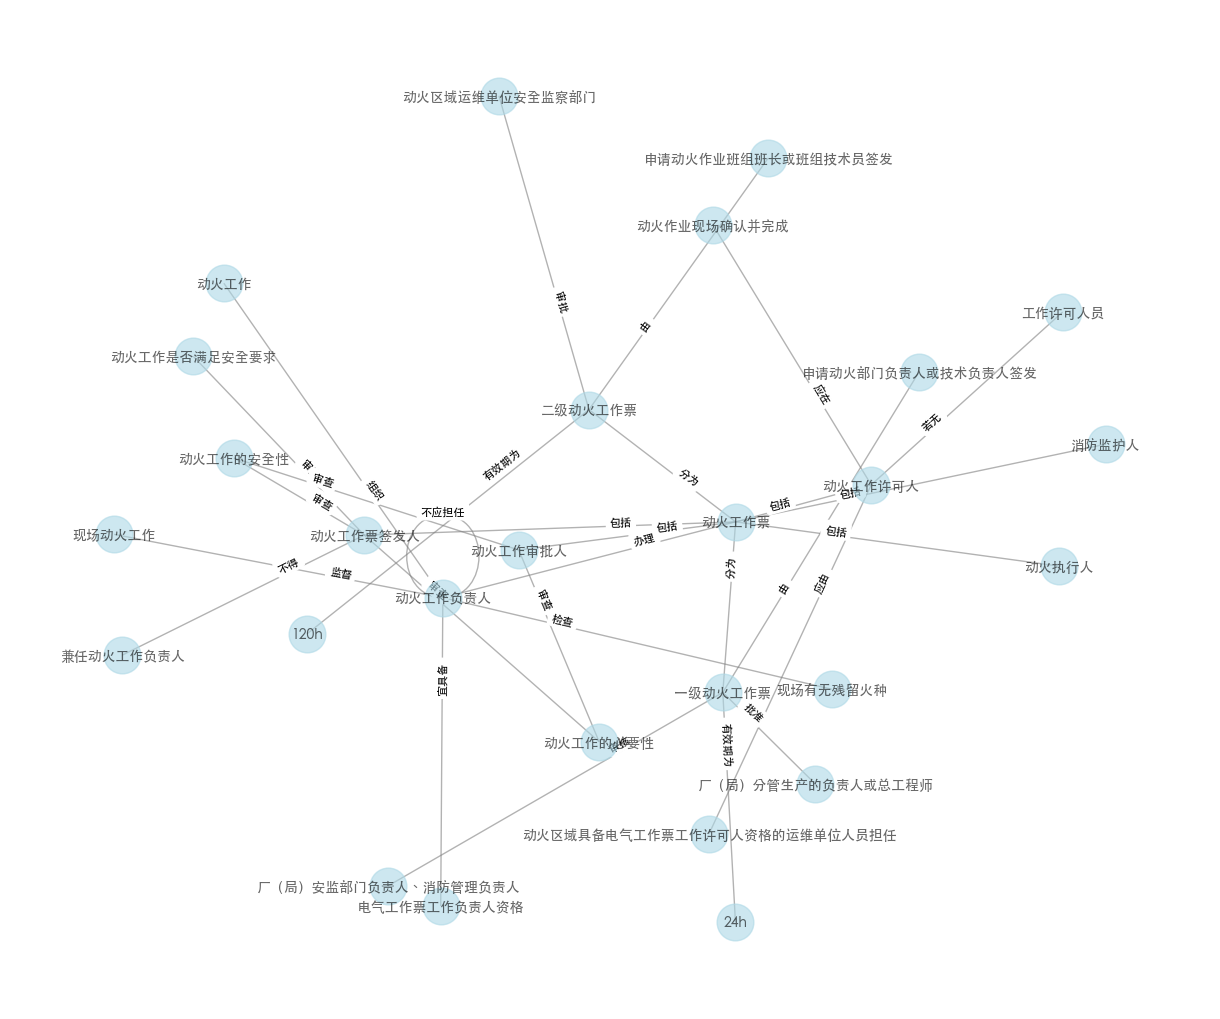

In [57]:
kg_fig = df_to_fig(extracted_triplets, show_fig=True)